In [2]:
import numpy as np
import matplotlib.pyplot as plt
from neurodiffeq import diff
from neurodiffeq.solvers import Solver1D, Solver2D
from neurodiffeq.conditions import IVP, DirichletBVP2D
from neurodiffeq.networks import FCNN, SinActv
from neurodiffeq.monitors import Monitor1D
from neurodiffeq.ode import solve
import torch

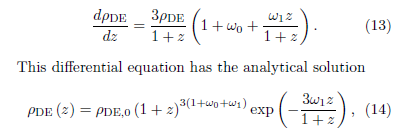

This a problem of initial value, where:
$$\rho_{DE,0}=\rho_{DE}(z=0)$$

In [2]:
#initial conditions and constants
w0=-1
w1=-2
rho_0 = 0.3 #J/m3

z0=0
zf=14

epochs=5000

<IPython.core.display.Javascript object>


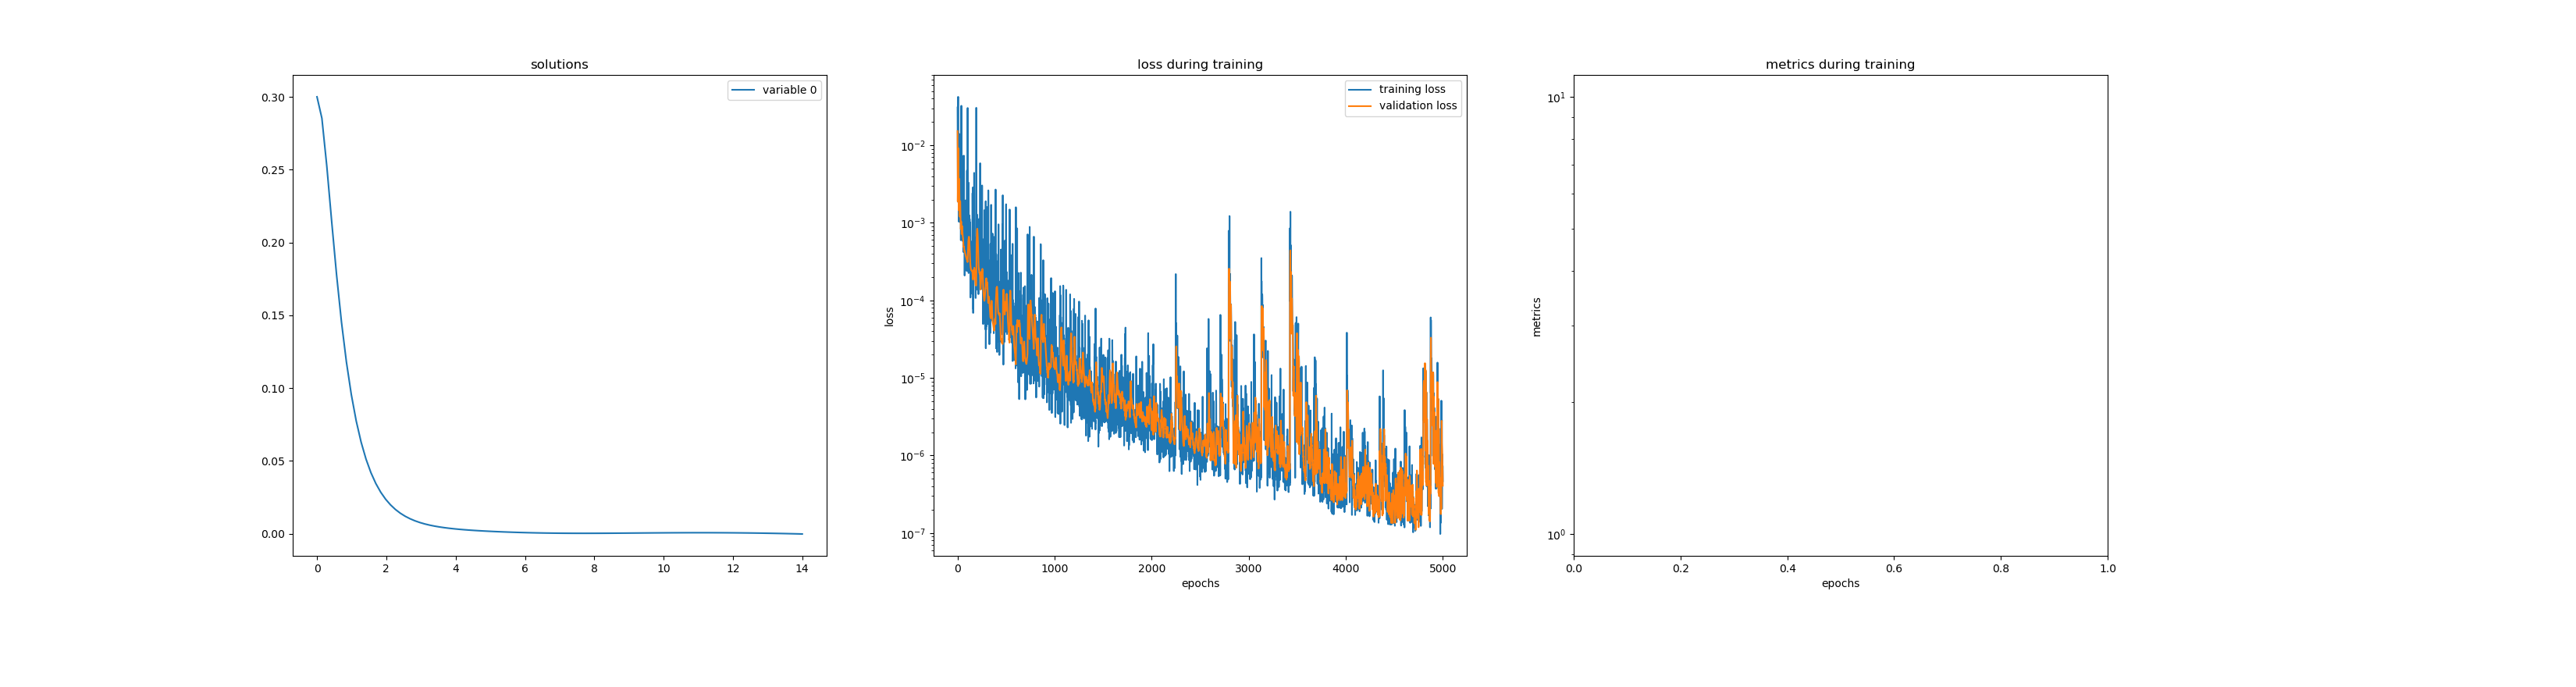

D:\Programas\Anaconda2\lib\site-packages\neurodiffeq\ode.py:260: FutureWarning: The `solve_system` function is deprecated, use a `neurodiffeq.solvers.Solver1D` instance instead
  warnings.warn(
D:\Programas\Anaconda2\lib\site-packages\neurodiffeq\solvers.py:459: UserWarning: Passing `monitor` is deprecated, use a MonitorCallback and pass a list of callbacks instead
  warnings.warn("Passing `monitor` is deprecated, "


Training Progress:   0%|                                                                      | 0/5000 [00:00<…

In [3]:
#lets define the ODE

PDE = lambda rho, z: diff(rho, z) - 3*rho/(1+z) * (1+w0+w1*z/(1+z))  # specify the ODE
rho_DE_0 = IVP(t_0=0.0, u_0=rho_0)       # specify the initial conditon

# solve the ODE
%matplotlib notebook

solution_ex, loss_ex = solve(
    ode=PDE, condition=rho_DE_0, t_min=z0, t_max=zf,
    max_epochs=epochs,
    monitor=Monitor1D(t_min=z0, t_max=zf, check_every=50)
)

In [4]:
def rhoDE(z):
    return rho_0*(1+z)**(3*(1+w0+w1)) * np.exp(-3*w1*z/(1+z))

<IPython.core.display.Javascript object>


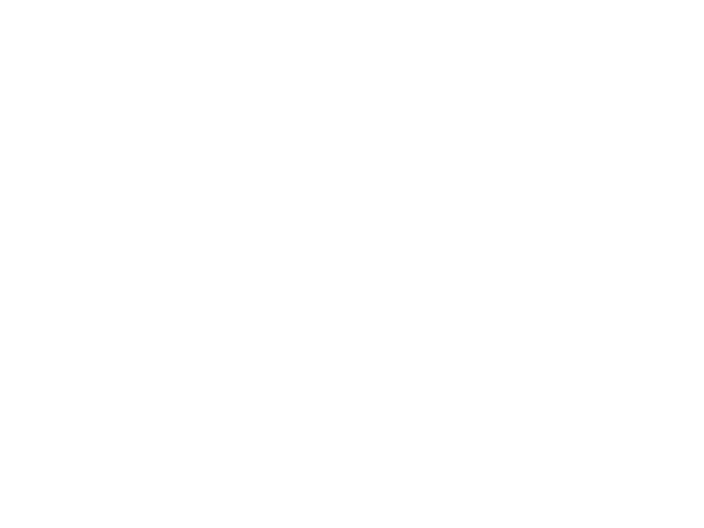

In [5]:
Z = np.linspace(0, 14, 50) #Domain
u_net = solution_ex(Z, to_numpy=True) #ANN, regresa una función que debe ser evaluada
sol=rhoDE(Z)

plt.figure()
plt.plot(Z, u_net, label='ANN-based solution')
plt.plot(Z, sol, '.', label='analytical solution')
plt.ylabel('$\\rho_{DE}$')
plt.xlabel('redshift')
plt.title('comparing solutions')
plt.legend()

<IPython.core.display.Javascript object>


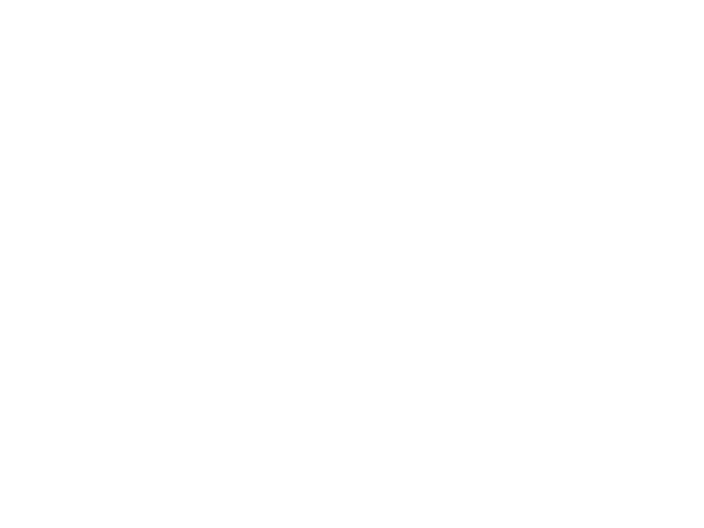

In [6]:
#error relativo
err=abs(u_net - sol)/abs(sol)


plt.figure()
plt.plot(Z, err, '.', label='analytical solution')
plt.ylabel('erreor')
plt.xlabel('redshift')
plt.title('Error relativo')
plt.legend()

In [7]:
#Comparación de los tiempos de evaluación
from scipy.integrate import odeint

def eq_rho(rho,z):
    return 3*rho/(1+z) * (1+w0+w1*z/(1+z))

In [8]:
odeint_sol = odeint(eq_rho, rho_0, Z)

<IPython.core.display.Javascript object>


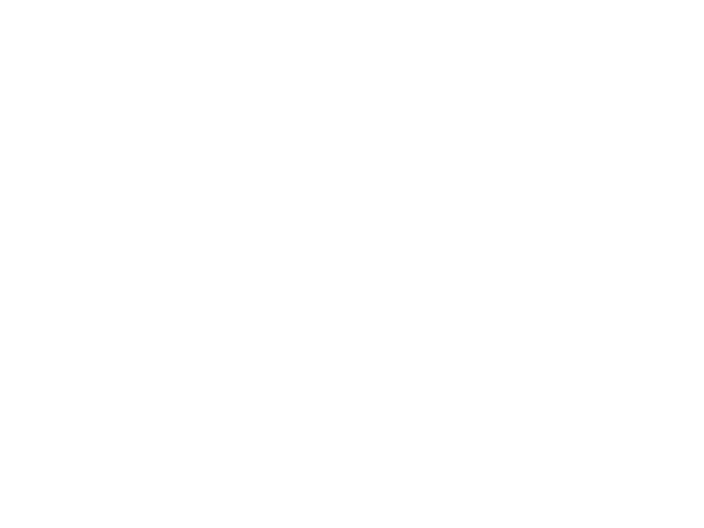

In [9]:
plt.figure()
plt.plot(Z,odeint_sol, label='Odeint-based solution')
plt.ylabel('$\\rho_{DE}$')
plt.plot(Z, sol, '.', label='analytical solution')
plt.xlabel('redshift')
plt.title('comparing solutions')
plt.legend()

In [10]:
#tiempos
%timeit odeint_sol = odeint(eq_rho, rho_0, Z)

966 µs ± 3.61 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [11]:
%timeit u_net = solution_ex(Z, to_numpy=True)

244 µs ± 8.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


# Checar si se pueden poner las soluciones

In [3]:
from scipy.integrate import odeint

In [4]:
#constants
gm = 0
gr= 1.0/3.0
gl= -1

#density parameters measured today
Or0 = 0.0001
Om0 = 0.3
Ol0 = 1-Or0-Om0

#Epochs
epochs = 20000

#Domain
Ni=0
Nf=-12

In [5]:
#system
continuity = lambda Om,Or,Ol,N:[diff(Om,N) - 3*(gm*Om + gl*Ol + gr*Or - gm)*Om,
                                 diff(Or,N) - 3*(gm*Om + gl*Ol + gr*Or - gr)*Or,
                                 diff(Ol,N) - 3*(gm*Om + gl*Ol + gr*Or - gl)*Ol
                                 ]
#initial condditions
init_conditions = [Om0,Or0,Ol0]

In [6]:
def sistema(params,t):
    Om,Or,Ol=params
    return [- 3*(gm*Om + gl*Ol + gr*Or - gm)*Om,
                                 -3*(gm*Om + gl*Ol + gr*Or - gr)*Or,
                                 -3*(gm*Om + gl*Ol + gr*Or - gl)*Ol]

In [7]:
t = np.linspace(-12,0, 101)
sol = odeint(sistema, init_conditions, t)

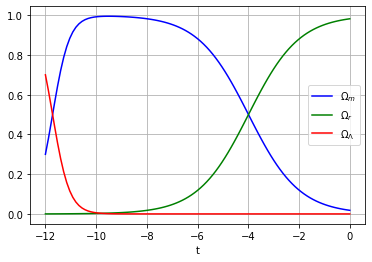

In [8]:
%matplotlib inline
plt.plot(t, sol[:, 0], 'b', label='$\Omega_m$')
plt.plot(t, sol[:, 1], 'g', label='$\Omega_r$')
plt.plot(t, sol[:, 2], 'r', label='$\Omega_ \Lambda$')
plt.legend(loc='best')
plt.xlabel('t')
plt.grid()

# Ahora con neuraldiff


In [9]:
from neurodiffeq import diff 
from neurodiffeq.ode import solve_system
from neurodiffeq.conditions import IVP
from neurodiffeq.monitors import Monitor1D
from neurodiffeq.solvers import Solver1D
import torch

<IPython.core.display.Javascript object>


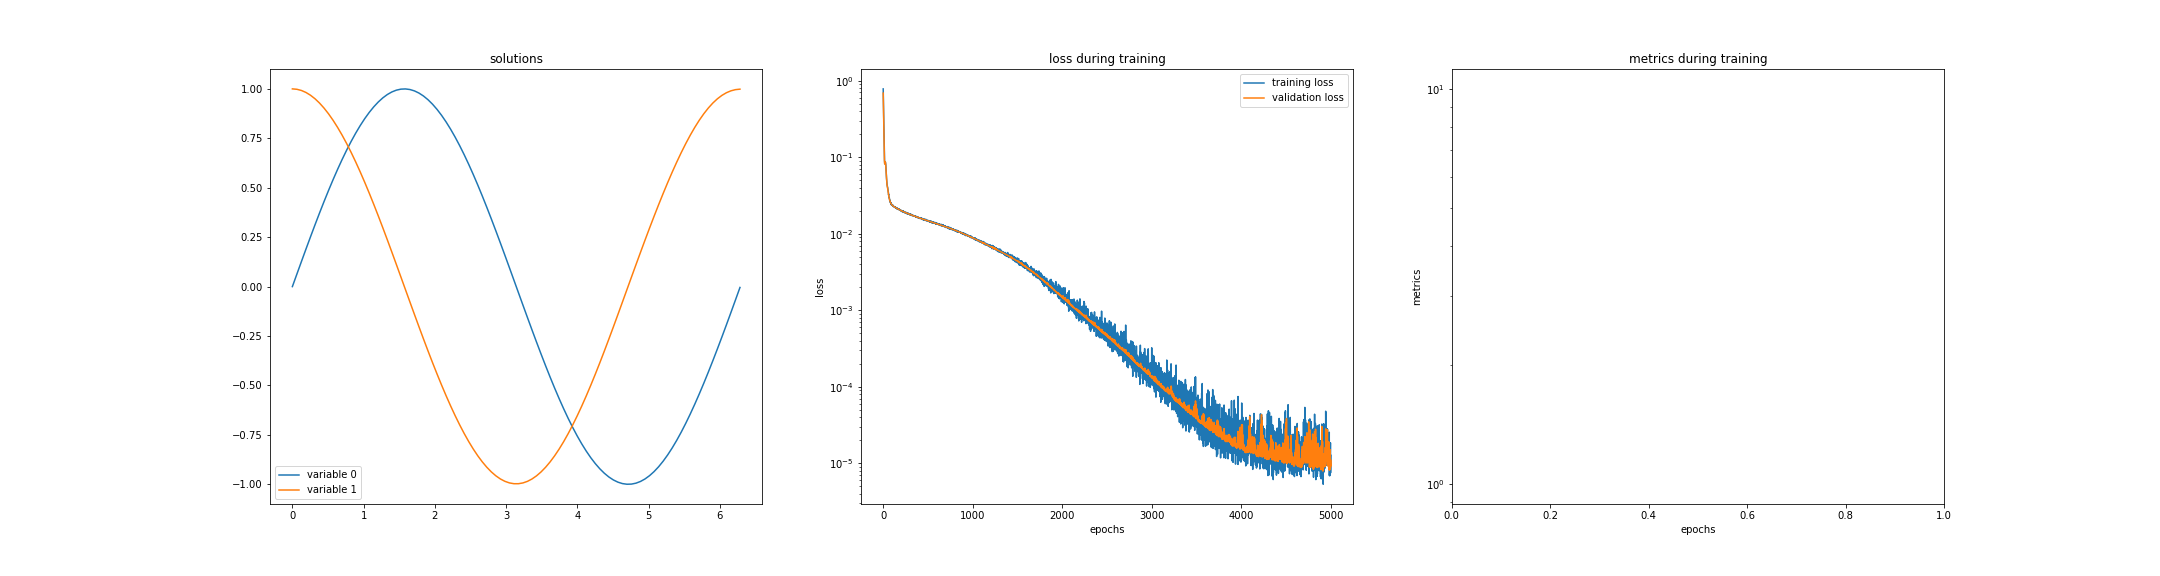

D:\Programas\Anaconda2\lib\site-packages\neurodiffeq\ode.py:260: FutureWarning: The `solve_system` function is deprecated, use a `neurodiffeq.solvers.Solver1D` instance instead
  warnings.warn(
D:\Programas\Anaconda2\lib\site-packages\neurodiffeq\solvers.py:459: UserWarning: Passing `monitor` is deprecated, use a MonitorCallback and pass a list of callbacks instead
  warnings.warn("Passing `monitor` is deprecated, "


Training Progress:   0%|                                                                      | 0/5000 [00:00<…

In [17]:
# specify the ODE system
%matplotlib notebook
parametric_circle = lambda u1, u2, t : [diff(u1, t) - u2,
diff(u2, t) + u1]
# specify the initial conditions
init_vals_pc = [
IVP(t_0=0.0, u_0=0.0),IVP(t_0=0.0, u_0=1.0)
]

# solve the ODE system
solution_pc, _ = solve_system(
ode_system=parametric_circle, conditions=init_vals_pc, t_min=0.0, t_max=2*np.pi,
max_epochs=5000,
monitor=Monitor1D(t_min=0.0, t_max=2*np.pi, check_every=100)
)

In [12]:
%matplotlib notebook

In [15]:
#system
continuity = lambda Om,Or,Ol,N:[diff(Om,N) - 3*(gm*Om + gl*Ol + gr*Or - gm)*Om,
                                 diff(Or,N) - 3*(gm*Om + gl*Ol + gr*Or - gr)*Or,
                                 diff(Ol,N) - 3*(gm*Om + gl*Ol + gr*Or - gl)*Ol
                                 ]
#initial condditions
init_conditions = [IVP(t_0=-12,u_0=Om0),
                   IVP(t_0=-12,u_0=Or0),
                   IVP(t_0=-12, u_0=Ol0)]

<IPython.core.display.Javascript object>


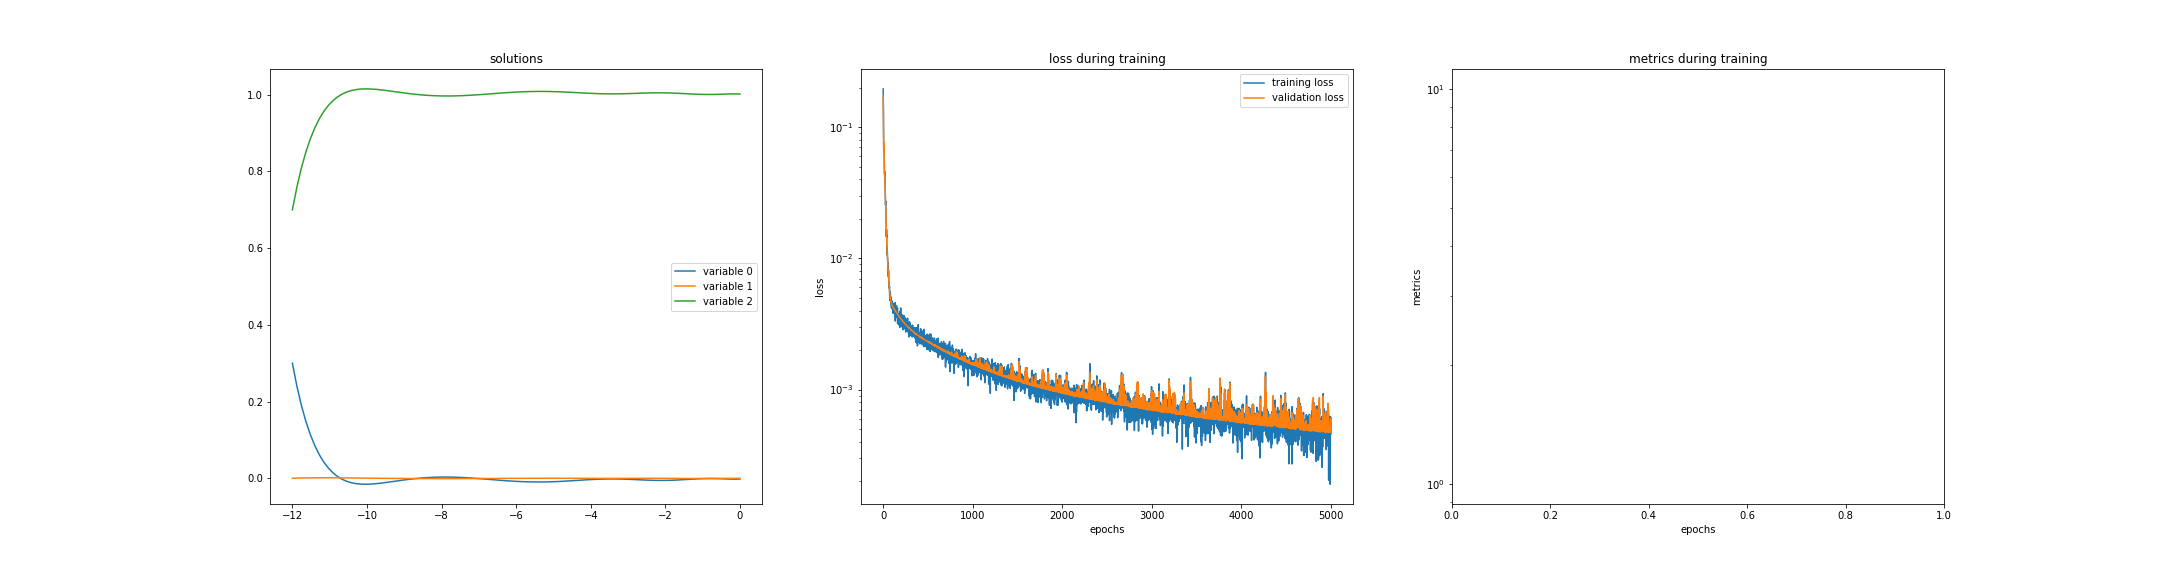

D:\Programas\Anaconda2\lib\site-packages\neurodiffeq\ode.py:260: FutureWarning: The `solve_system` function is deprecated, use a `neurodiffeq.solvers.Solver1D` instance instead
  warnings.warn(
D:\Programas\Anaconda2\lib\site-packages\neurodiffeq\solvers.py:459: UserWarning: Passing `monitor` is deprecated, use a MonitorCallback and pass a list of callbacks instead
  warnings.warn("Passing `monitor` is deprecated, "


Training Progress:   0%|                                                                      | 0/5000 [00:00<…

In [16]:
sol_params,_ = solve_system(ode_system=continuity,conditions=init_conditions,max_epochs=5000,
                            t_min=-12, t_max=0,
                            monitor=Monitor1D(t_min=-12, t_max=0, check_every=400)
                            )